In [ ]:
import sys
import importlib.metadata as md
print("Python", sys.version.split()[0])
for p in ["tensorflow","pandas","numpy","scikit-learn","shap"]:
    try: print(p, md.version(p))
    except: pass

This notebook runs in INTERACTIVE mode by default (no files are written).
Set NB_MODE = "PERSISTENT" to also save CSV/PNG/JSON under notebooks/outputs/NB1/.

In [1]:
# NB_MODE: controls whether artifacts are written to disk or just displayed inline
NB_MODE = 'INTERACTIVE'  # options: 'INTERACTIVE' (default), 'PERSISTENT'
if NB_MODE == 'INTERACTIVE':
    print('NB1 running in INTERACTIVE mode (no files will be written)')
else:
    print('NB1 running in PERSISTENT mode: artifacts will be written to notebooks/outputs/NB1/<timestamp>/')

NB1 running in INTERACTIVE mode (no files will be written)


In [2]:
# NB1-BOOT: Standard imports and run-scoped output dirs for NB1
import sys
from pathlib import Path
import json
import hashlib
from datetime import datetime
# Root for NB1 outputs (immutable per run under a timestamped folder)
OUT_BASE_ROOT = Path('notebooks') / 'outputs' / 'NB1'
TIMESTAMP = datetime.utcnow().strftime('%Y%m%d_%H%M%S')
RUN_DIR = OUT_BASE_ROOT / TIMESTAMP
FIG_DIR = RUN_DIR / 'figures'
TAB_DIR = RUN_DIR / 'tables'
MAN_DIR = RUN_DIR / 'manifests'
LOG_DIR = RUN_DIR / 'logs'
for d in (FIG_DIR, TAB_DIR, MAN_DIR, LOG_DIR):
    d.mkdir(parents=True, exist_ok=True)
# 'latest' mirror - will be refreshed at the end of the run (only in PERSISTENT mode)
LATEST_DIR = OUT_BASE_ROOT / 'latest'
OUT_BASE_ROOT.mkdir(parents=True, exist_ok=True)
print('NB1-BOOT Outputs ->', RUN_DIR)
print('NB1-BOOT Latest mirror ->', LATEST_DIR)

NB1-BOOT Outputs -> notebooks\outputs\NB1\20251027_004510
NB1-BOOT Latest mirror -> notebooks\outputs\NB1\latest


C:\Users\Administrador\AppData\Local\Temp\ipykernel_19488\2437685824.py:10: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  TIMESTAMP = datetime.utcnow().strftime('%Y%m%d_%H%M%S')


In [3]:
# NB1-BOOT: Environment detection: LOCAL / KAGGLE / COLAB
import os
def detect_env():
    if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ or 'KAGGLE_URL_BASE' in os.environ:
        return 'KAGGLE'
    try:
        return 'COLAB'
    except Exception:
        pass
    return 'LOCAL'
ENV = detect_env()
print('NB1-BOOT Environment ->', ENV)

NB1-BOOT Environment -> LOCAL


In [4]:
# NB1-BOOT: check required packages and instruct (no auto install). seaborn is NOT required for WORKCOPY
import importlib
import warnings
warnings.filterwarnings('ignore', message='pkg_resources is deprecated as an API')
REQUIRED = ['pandas', 'numpy', 'matplotlib']
missing = [r for r in REQUIRED if importlib.util.find_spec(r) is None]
if missing:
    print('NB1-BOOT Missing packages:', missing)
    print('Install with: ', sys.executable + ' -m pip install ' + ' '.join(missing))
else:
    print('NB1-BOOT All required packages present')
# Safe imports (user may have installed them)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

NB1-BOOT All required packages present


In [5]:
# NB1-PATHS: resolve features_daily.csv (LOCAL/KAGGLE) with robust fallbacks
import re
from glob import glob
from pathlib import Path

# Optional: force a specific snapshot (YYYY-MM-DD) via env
SNAPSHOT_DATE = os.environ.get("SNAPSHOT_DATE", "").strip()

# 1) Explicit overrides (variable or env)
if 'FEATURES_CSV' in globals() and FEATURES_CSV:
    INPUT_CSV = Path(FEATURES_CSV)
    print('NB1-PATHS Using FEATURES_CSV override ->', INPUT_CSV)
elif os.environ.get('FEATURES_CSV'):
    INPUT_CSV = Path(os.environ.get('FEATURES_CSV'))
    print('NB1-PATHS Using FEATURES_CSV env override ->', INPUT_CSV)
else:
    chosen = None
    tried = []

    if ENV == 'KAGGLE':
        patterns = ['/kaggle/input/**/features_daily.csv']
        for pat in patterns:
            tried.append(pat)
            cands = glob(pat, recursive=True)
            if SNAPSHOT_DATE:
                cands = [p for p in cands if re.search(rf'[\\/]{re.escape(SNAPSHOT_DATE)}[\\/]', p)]
            if cands:
                # pick first (Kaggle datasets usually single-match)
                chosen = sorted(cands)[0]
                print(f'NB1-PATHS (KAGGLE) candidates_total={len(cands)}')
                break
    else:
        # LOCAL: search from CWD and its parents to tolerate running from /notebooks
        roots = [Path.cwd()] + list(Path.cwd().parents)
        patterns_rel = [
            'data/etl/*/snapshots/*/joined/features_daily.csv',
            '**/data/etl/*/snapshots/*/joined/features_daily.csv',
        ]
        cands_all = []
        for base in roots:
            for pat in patterns_rel:
                full = str(base / pat)
                tried.append(full)
                cands = glob(full, recursive=True)
                cands_all.extend(cands)

        # Optional filter by SNAPSHOT_DATE (YYYY-MM-DD)
        if SNAPSHOT_DATE:
            cands_all = [p for p in cands_all if re.search(rf'[\\/]{re.escape(SNAPSHOT_DATE)}[\\/]', p)]

        # Choose by most recent snapshot date if available
        dated = []
        for p in cands_all:
            m = re.search(r'[\\/](?:snapshots)[\\/]([0-9]{4}-[0-9]{2}-[0-9]{2})[\\/]', p)
            dated.append((p, m.group(1) if m else '0000-00-00'))

        if dated:
            dated.sort(key=lambda x: x[1], reverse=True)
            chosen = dated[0][0]

        print(f'NB1-PATHS (LOCAL) candidates_total={len(cands_all)}')

    if not chosen:
        msg = "NEED:\n- <FEATURES_CSV not found in LOCAL/KAGGLE>\n- patterns tried:\n  " + "\n  ".join(tried[:15] + (["..."] if len(tried) > 15 else []))
        raise FileNotFoundError(msg)

    INPUT_CSV = Path(chosen)
    print('NB1-PATHS Selected INPUT_CSV ->', INPUT_CSV)

# 2) Sanity + SHA256
def sha256_file(p: Path) -> str:
    import hashlib
    h = hashlib.sha256()
    with open(p, "rb") as f:
        for chunk in iter(lambda: f.read(1<<20), b""):
            h.update(chunk)
    return h.hexdigest()

if not INPUT_CSV.exists() or INPUT_CSV.stat().st_size == 0:
    raise FileNotFoundError(f"NEED:\n- <corrupted or empty file>\n- path: {INPUT_CSV}")

INPUT_SHA256 = sha256_file(INPUT_CSV)
print('NB1-PATHS INPUT_SHA256 ->', INPUT_SHA256)


NB1-PATHS (LOCAL) candidates_total=4
NB1-PATHS Selected INPUT_CSV -> c:\dev\practicum2-nof1-adhd-bd\data\etl\P000001\snapshots\2025-10-22\joined\features_daily.csv
NB1-PATHS INPUT_SHA256 -> 0a9e7b2eab23e34789815eee163e80d7ed7287bab3e9146359d8b34944018c72


In [6]:
# DIAGNOSTIC: show first lines and sample columns
print('NB1-PATHS INPUT_CSV ->', INPUT_CSV)
print('Exists ->', INPUT_CSV.exists())
print('Size ->', getattr(INPUT_CSV.stat(), 'st_size', 'n/a'))
print('--- first 10 raw lines ---')
with INPUT_CSV.open('r', encoding='utf-8', errors='replace') as fh:
    for i, line in enumerate(fh):
        print(f'{i+1}: {line.rstrip()}')
        if i >= 9:
            break
# pandas sample
try:
    sample = pd.read_csv(INPUT_CSV, nrows=5)
    print('Detected columns:', list(sample.columns))
except Exception as e:
    print('pandas.sample failed:', e)

NB1-PATHS INPUT_CSV -> c:\dev\practicum2-nof1-adhd-bd\data\etl\P000001\snapshots\2025-10-22\joined\features_daily.csv
Exists -> True
Size -> 61576
--- first 10 raw lines ---
1: date,apple_hr_mean,apple_hr_std,apple_n_hr,zepp_hr_mean,zepp_hr_std,zepp_n_hr
2: 2021-05-14,70.15276,13.114134,779.0,,,
3: 2021-05-15,65.795259,12.197685,464.0,,,
4: 2021-05-16,68.206166,12.619444,519.0,,,
5: 2021-05-17,67.290816,19.564835,392.0,,,
6: 2021-05-18,70.808989,23.058244,445.0,,,
7: 2021-05-19,67.469352,17.886302,571.0,,,
8: 2021-05-20,70.820919,18.149789,631.0,,,
9: 2021-05-21,64.104784,10.602916,439.0,,,
10: 2021-05-22,64.430303,9.781073,660.0,,,
Detected columns: ['date', 'apple_hr_mean', 'apple_hr_std', 'apple_n_hr', 'zepp_hr_mean', 'zepp_hr_std', 'zepp_n_hr']


In [7]:
# NB1-LOAD: Load dataframe and apply tolerant schema guards (prefer 'date')
try:
    df = pd.read_csv(INPUT_CSV)
except FileNotFoundError:
    raise FileNotFoundError('<FEATURES_CSV não encontrado em LOCAL>')
except Exception as e:
    raise ValueError('<arquivo corrompido ou vazio>') from e
print('NB1-LOAD rows, cols =', df.shape)
# Prefer 'date' column; fallback to 'date_utc' if 'date' missing
if 'date' in df.columns:
    DATE_COL = 'date'
    print("NB1-LOAD Using date column: 'date'")
elif 'date_utc' in df.columns:
    DATE_COL = 'date'
    df[DATE_COL] = df['date_utc']
    print("NB1-LOAD Mapped 'date_utc' -> 'date'")
else:
    raise ValueError("<coluna de data ausente: 'date' ou 'date_utc'>")
# Normalize date column to datetime, drop invalid rows, sort
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors='coerce')
before_drop = len(df)
df = df.dropna(subset=[DATE_COL])
dropped = before_drop - len(df)
if dropped > 0:
    print(f'NB1-LOAD Dropped {dropped} rows with invalid {DATE_COL}')
df = df.sort_values(by=[DATE_COL]).reset_index(drop=True)
# Tolerant available cols
available_cols = list(df.columns)
print('NB1-LOAD Available columns (sample):', available_cols[:20])
# Segment info (optional)
has_segment = 'segment_id' in df.columns
segment_counts = None
if has_segment:
    segment_counts = df['segment_id'].value_counts().to_dict()
    print('NB1-LOAD segment counts (sample):', dict(list(segment_counts.items())[:10]))

NB1-LOAD rows, cols = (1296, 7)
NB1-LOAD Using date column: 'date'
NB1-LOAD Available columns (sample): ['date', 'apple_hr_mean', 'apple_hr_std', 'apple_n_hr', 'zepp_hr_mean', 'zepp_hr_std', 'zepp_n_hr']


NB1-EDA Detected numeric features count -> 6
NB1-EDA df.head(10) preview:


,date,apple_hr_mean,apple_hr_std,apple_n_hr,zepp_hr_mean,zepp_hr_std,zepp_n_hr
0,2021-05-14,70.152760,13.114134,779.0,NaN,NaN,NaN
1,2021-05-15,65.795259,12.197685,464.0,NaN,NaN,NaN
2,2021-05-16,68.206166,12.619444,519.0,NaN,NaN,NaN
3,2021-05-17,67.290816,19.564835,392.0,NaN,NaN,NaN
4,2021-05-18,70.808989,23.058244,445.0,NaN,NaN,NaN
5,2021-05-19,67.469352,17.886302,571.0,NaN,NaN,NaN
6,2021-05-20,70.820919,18.149789,631.0,NaN,NaN,NaN
7,2021-05-21,64.104784,10.602916,439.0,NaN,NaN,NaN
8,2021-05-22,64.430303,9.781073,660.0,NaN,NaN,NaN
9,2021-05-23,70.445736,11.331807,258.0,NaN,NaN,NaN


NB1-EDA summary stats (numeric features):


,count,mean,std,min,25%,50%,75%,max
apple_hr_mean,1186.0,85.639727,21.692715,0.000000,65.292183,86.865295,103.310440,148.059299
apple_hr_std,1186.0,14.014852,5.439494,0.000000,11.158508,13.948677,16.954451,36.345174
apple_n_hr,1186.0,2809.577572,3785.935385,1.000000,439.000000,974.500000,4144.500000,25210.000000
zepp_hr_mean,486.0,74.052194,7.745670,52.328302,69.218903,74.260853,78.535640,101.852273
zepp_hr_std,486.0,16.846297,3.749136,0.500000,14.811558,16.858149,19.190524,33.017021
zepp_n_hr,486.0,886.547325,513.348567,2.000000,476.500000,847.000000,1409.750000,1440.000000


NB1-EDA missingness (percent):


,missing_pct
zepp_n_hr,62.500000
zepp_hr_std,62.500000
zepp_hr_mean,62.500000
apple_hr_mean,8.487654
apple_hr_std,8.487654
apple_n_hr,8.487654
date,0.000000


NB1-EDA correlation matrix (top variance features):


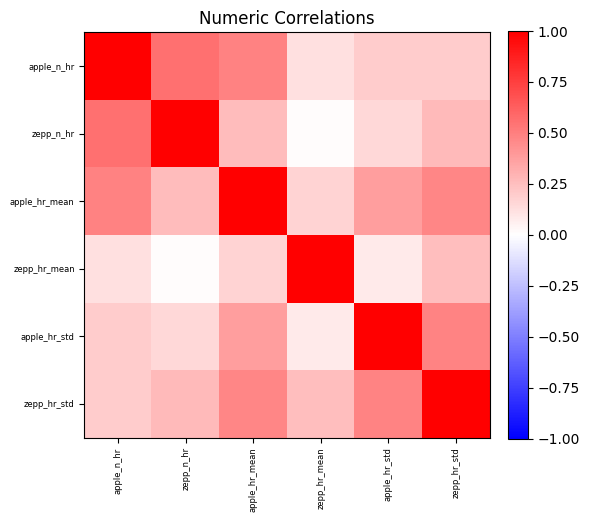

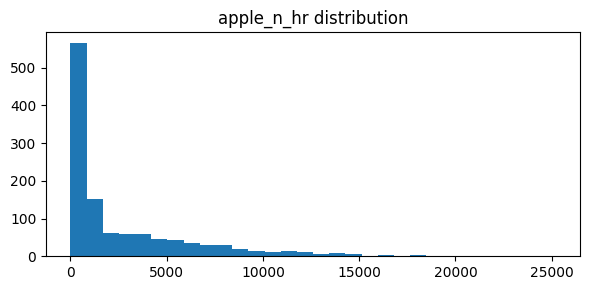

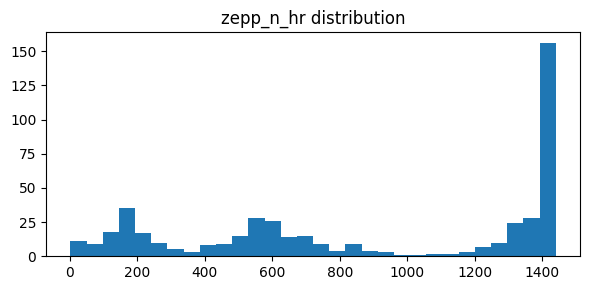

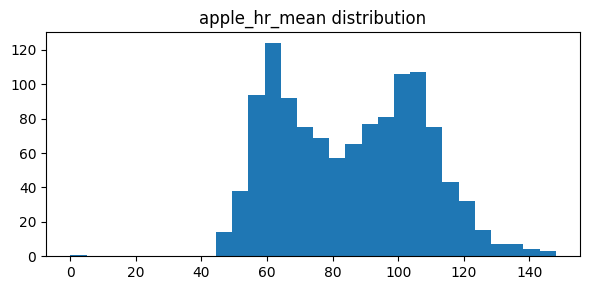

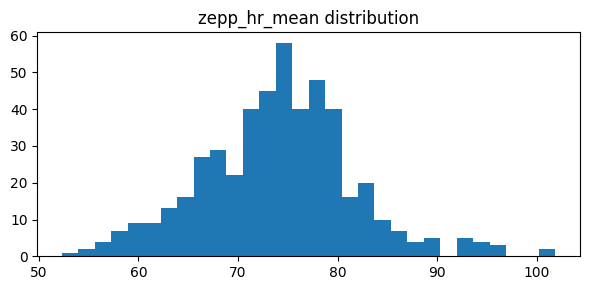

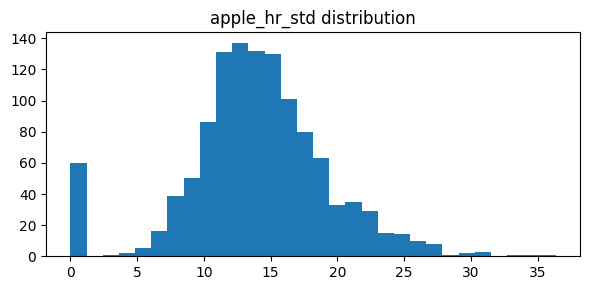

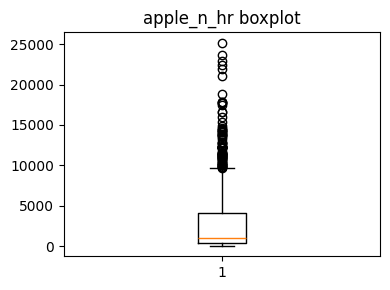

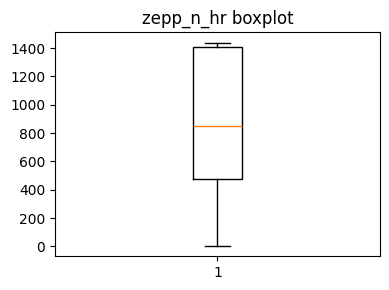

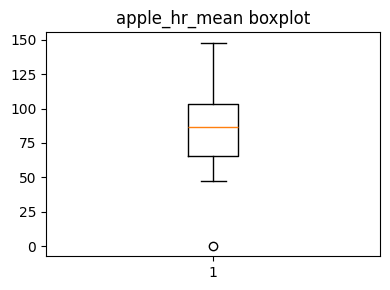

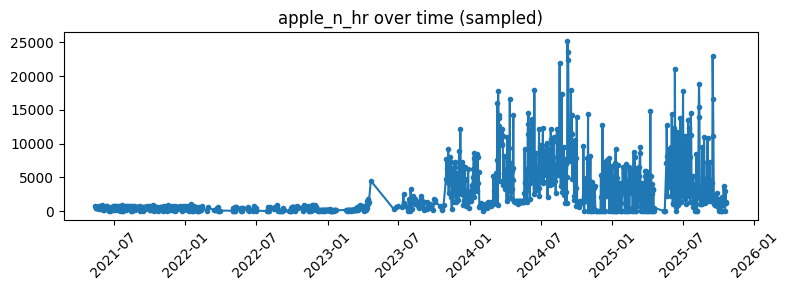

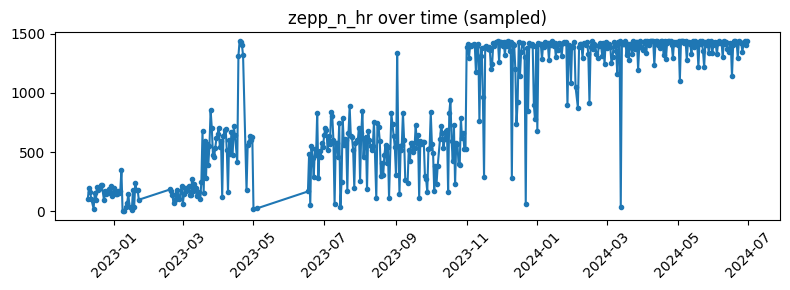

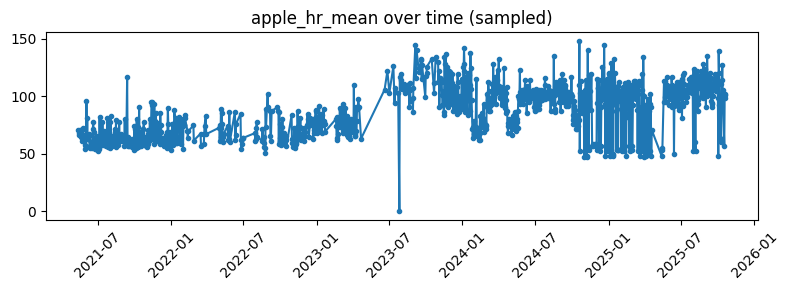

(preview only) NB1-EDA ran in INTERACTIVE mode; no artifacts written


In [8]:
# NB1-EDA: keep EDA from recover (adapted to matplotlib-only and NB_MODE gating)
exclude_cols = {'date', 'segment_id', 'version_id', 'participant_id'}
numeric_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in exclude_cols]
print('NB1-EDA Detected numeric features count ->', len(numeric_cols))
# Head (first 10 rows) - display inline
print('NB1-EDA df.head(10) preview:')
display(df.head(10))
# Summary stats - display inline
summary = df[numeric_cols].describe().transpose() if numeric_cols else pd.DataFrame()
print('NB1-EDA summary stats (numeric features):')
display(summary)
# Missingness (percent) - display inline
miss = pd.DataFrame({'missing_pct': df.isna().mean() * 100})
print('NB1-EDA missingness (percent):')
display(miss.sort_values('missing_pct', ascending=False).head(50))
# Correlations limited to top-variance 50 features - compute and display inline
MAX_CORR_FEATURES = 50
if numeric_cols:
    variances = df[numeric_cols].var(skipna=True).sort_values(ascending=False)
    top = list(variances.index[:MAX_CORR_FEATURES])
    corr = df[top].corr(method='pearson')
    print('NB1-EDA correlation matrix (top variance features):')
    # Matplotlib heatmap inline
    fig, ax = plt.subplots(figsize=(6,6))
    cax = ax.imshow(corr.values, cmap='bwr', vmin=-1, vmax=1)
    ax.set_xticks(range(len(corr.columns)))
    ax.set_yticks(range(len(corr.index)))
    ax.set_xticklabels(corr.columns, rotation=90, fontsize=6)
    ax.set_yticklabels(corr.index, fontsize=6)
    fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04)
    plt.title('Numeric Correlations')
    plt.tight_layout()
    display(fig)
    plt.close(fig)
else:
    print('NB1-EDA Not enough numeric columns for correlations')
# Histograms (3-5 top-variance numeric features) - inline; do not require seaborn
NUM_HISTS = 5
if numeric_cols:
    top_vars = list(df[numeric_cols].var().sort_values(ascending=False).index[:NUM_HISTS])
    for col in top_vars:
        try:
            fig, ax = plt.subplots(figsize=(6,3))
            ax.hist(df[col].dropna(), bins=30, color='C0')
            ax.set_title(f'{col} distribution')
            plt.tight_layout()
            display(fig)
            if NB_MODE == 'PERSISTENT':
                fig.savefig(FIG_DIR / f'{col}_hist.png', dpi=150)
                print('NB1-OUT Wrote', col, 'hist ->', FIG_DIR / f'{col}_hist.png')
            plt.close(fig)
        except Exception as e:
            print('NB1-EDA could not render histogram for', col, e)
# Boxplots for up to 3 of the same top features
NUM_BOX = 3
for col in top_vars[:NUM_BOX]:
    try:
        fig, ax = plt.subplots(figsize=(4,3))
        ax.boxplot(df[col].dropna())
        ax.set_title(f'{col} boxplot')
        plt.tight_layout()
        display(fig)
        if NB_MODE == 'PERSISTENT':
            fig.savefig(FIG_DIR / f'{col}_box.png', dpi=150)
            print('NB1-OUT Wrote', col, 'boxplot ->', FIG_DIR / f'{col}_box.png')
        plt.close(fig)
    except Exception as e:
        print('NB1-EDA could not render boxplot for', col, e)
# Sampled time-series (up to 3 features), sampling to MAX_POINTS for plotting
MAX_POINTS = 5000
NUM_TS = 3
ts_features = top_vars[:NUM_TS] if numeric_cols else []
for col in ts_features:
    try:
        s = df[[DATE_COL, col]].dropna().sort_values(by=DATE_COL)
        if len(s) > MAX_POINTS:
            s = s.sample(MAX_POINTS, random_state=0).sort_values(by=DATE_COL)
        fig, ax = plt.subplots(figsize=(8,3))
        ax.plot(s[DATE_COL], s[col], marker='.', linestyle='-')
        ax.set_title(f'{col} over time (sampled)')
        plt.xticks(rotation=45)
        plt.tight_layout()
        display(fig)
        if NB_MODE == 'PERSISTENT':
            fig.savefig(FIG_DIR / f'{col}_timeseries.png', dpi=150)
            print('NB1-OUT Wrote', col, 'timeseries ->', FIG_DIR / f'{col}_timeseries.png')
        plt.close(fig)
    except Exception as e:
        print('NB1-EDA could not render timeseries for', col, e)
# In INTERACTIVE mode, do not write tables/CSVs; in PERSISTENT mode, write summary tables
if NB_MODE == 'PERSISTENT':
    try:
        summary.to_csv(TAB_DIR / 'summary_stats.csv', index=True)
        df.head(10).to_csv(TAB_DIR / 'head.csv', index=False)
        miss.to_csv(TAB_DIR / 'missingness_pct.csv')
        corr.to_csv(TAB_DIR / 'correlations.csv')
        print('NB1-OUT Wrote summary/head/missingness/correlations ->', TAB_DIR)
    except Exception as e:
        print('NB1-OUT Could not write tables:', e)
else:
    print('(preview only) NB1-EDA ran in INTERACTIVE mode; no artifacts written')

In [9]:
# NB1-OUT: write run manifest, logs, and refresh latest mirror (gated by NB_MODE)
import shutil
def lib_version(name: str) -> str:
    try:
        import pkg_resources
        return pkg_resources.get_distribution(name).version
    except Exception:
        try:
            import importlib
            m = importlib.import_module(name)
            return getattr(m, '__version__', 'unknown')
        except Exception:
            return 'unknown'
manifest = {
    'env': ENV,
    'python_executable': sys.executable,
    'input': {'path': str(INPUT_CSV), 'sha256': INPUT_SHA256},
    'rows': int(df.shape[0]),
    'cols': int(df.shape[1]),
    'date_min': str(df[DATE_COL].min()),
    'date_max': str(df[DATE_COL].max()),
    'numeric_features': list(numeric_cols),
    'has_segment_id': bool(has_segment),
}
if has_segment:
    manifest['segment_counts'] = segment_counts
manifest['artifacts'] = []
for p in sorted(TAB_DIR.glob('*')) + sorted(FIG_DIR.glob('*')):
    if p.is_file():
        try:
            s = hashlib.sha256(p.read_bytes()).hexdigest()
        except Exception:
            s = 'error'
        manifest['artifacts'].append({'path': str(p), 'sha256': s})
# If persistent, write manifest/log and refresh latest mirror. Otherwise print preview
manifest_path = MAN_DIR / 'run_manifest.json'
if NB_MODE == 'PERSISTENT':
    with manifest_path.open('w', encoding='utf-8') as f:
        json.dump(manifest, f, indent=2, sort_keys=True)
    print('NB1-OUT Wrote run manifest ->', manifest_path)
    # Write log
    log_path = LOG_DIR / 'run.log'
    with log_path.open('a', encoding='utf-8') as fh:
        fh.write('NB1-BOOT TIMESTAMP=' + TIMESTAMP + '\n')
        fh.write('NB1-PATHS INPUT=' + str(INPUT_CSV) + ' SHA256=' + INPUT_SHA256 + '\n')
        fh.write('NB1-LOAD rows=' + str(df.shape[0]) + ' cols=' + str(df.shape[1]) + '\n')
        fh.write('NB1-EDA num_features=' + str(len(numeric_cols)) + '\n')
    print('NB1-OUT Wrote log ->', log_path)
    # Refresh latest mirror
    try:
        if LATEST_DIR.exists():
            shutil.rmtree(LATEST_DIR)
        shutil.copytree(RUN_DIR, LATEST_DIR)
        print('NB1-OUT Refreshed latest mirror ->', LATEST_DIR)
    except Exception as e:
        print('NB1-OUT Could not refresh latest mirror:', e)
else:
    print('(preview only) NB1-OUT manifest/log/latest mirror suppressed in INTERACTIVE mode')
# Final console summary prints (always shown)
num_missing_over_20 = int((df.isna().mean() * 100 > 20).sum())
num_const_cols = int((df.nunique(dropna=False) <= 1).sum())
print('NB1-RESULT ENV=', ENV)
print('NB1-RESULT INPUT=', INPUT_CSV, 'SHA256=', INPUT_SHA256)
print('NB1-RESULT rows,cols=', df.shape)
print('NB1-RESULT date_range=', str(df[DATE_COL].min()), '->', str(df[DATE_COL].max()))
print('NB1-RESULT #num_features=', len(numeric_cols), '#missing>20%=', num_missing_over_20, '#const_cols=', num_const_cols)
print('NB1-RESULT run_dir=', RUN_DIR)
print('NB1-RESULT latest_mirror=', LATEST_DIR)

(preview only) NB1-OUT manifest/log/latest mirror suppressed in INTERACTIVE mode
NB1-RESULT ENV= LOCAL
NB1-RESULT INPUT= c:\dev\practicum2-nof1-adhd-bd\data\etl\P000001\snapshots\2025-10-22\joined\features_daily.csv SHA256= 0a9e7b2eab23e34789815eee163e80d7ed7287bab3e9146359d8b34944018c72
NB1-RESULT rows,cols= (1296, 7)
NB1-RESULT date_range= 2021-05-14 00:00:00 -> 2025-10-21 00:00:00
NB1-RESULT #num_features= 6 #missing>20%= 3 #const_cols= 0
NB1-RESULT run_dir= notebooks\outputs\NB1\20251027_004510
NB1-RESULT latest_mirror= notebooks\outputs\NB1\latest


Notes:
- Outputs are saved under `notebooks/outputs/NB1/<TIMESTAMP>/` with `tables`, `figures`, `manifests`, and `logs` (when NB_MODE='PERSISTENT').
- `latest/` is a mirror of the most recent run (refreshed only in PERSISTENT mode).
- If the notebook raises one of the special block messages, act as follows:
  - `<FEATURES_CSV não encontrado em LOCAL>`: place the CSV under `data/etl/<PID>/snapshots/<SNAP>/joined/features_daily.csv` or set `FEATURES_CSV` env/variable.
  - `<coluna de data ausente: 'date' ou 'date_utc'>`: ensure the dataset has a `date` or `date_utc` column.
  - `<arquivo corrompido ou vazio>`: inspect the CSV file for corruption or empty content.